In [11]:
import tensorflow as tf
import numpy as np
import os, re, math
from matplotlib import pyplot as plt
import matplotlib as mpl
import utils_box as box
AUTO = tf.data.AUTOTUNE

# Data source configuration

In [12]:
DATA_PATH_PATTERN = 'gs://practical-ml-vision-book/arthropod_detection_tfr/size_w1024px/*.tfrec'

RAW_CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
               '_truncated', '_blurred', '_occluded', ]
CLASSES = [klass for klass in RAW_CLASSES if klass not in ['_truncated', '_blurred', '_occluded', ]]

# Lepidoptera = butterfies and moths
# Hymenoptera = wasps, bees and ants
# Hemiptera = true bugs (cicadas, aphids, shield bugs, ...)
# Odonata = dragonflies
# Diptera = fies
# Araneae = spiders
# Coleoptera = beetles

# NOT IN DATASET
# Orthoptera = grasshoppers

# Display utilities

In [13]:
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

def display_detections(images, offsets, resizes, detections, classnames, ground_truth_boxes=[]):
    # scale and offset the detected boxes back to original image coordinates
    boxes   = [[ (x,y,w,h)  for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    boxes   = [[ (x-ofs[1], y-ofs[0], w, h) for x,y,w,h in boxlist ] for boxlist, ofs in zip(boxes, offsets)]
    boxes   = [[ (x*rsz, y*rsz, w*rsz, h*rsz) for x,y,w,h in boxlist ] for boxlist, rsz in zip(boxes, resizes)]
    classes = [[ int(klass) for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    scores  = [[ score      for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes)
    
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(math.ceil(math.sqrt(N)))
    aspect = sum([im.shape[1]/im.shape[0] for im in images])/len(images) # mean aspect ratio of images
    fig = plt.figure(figsize=(15,15/aspect), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            #label = classnames[klass-1] # predicted classes are 1-based
            label = classnames[klass]
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

# Dataset

In [14]:
def read_tfrecord(example):
    feature = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string), # compressed image bytes
        "image/source_id": tf.io.FixedLenFeature([], tf.string),  # string
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64) # one tag per box
    }
    example = tf.io.parse_single_example(example, feature)
    source_id = example['image/source_id']
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    boxes_xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    boxes_xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    boxes_ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    boxes_ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = tf.stack([boxes_xmin, boxes_ymin, boxes_xmax, boxes_ymax], axis=-1)
    labels = tf.sparse.to_dense(example['image/object/class/label'])
    return image, source_id, boxes, labels
    
def load_tfrecord_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [15]:
filenames = tf.io.gfile.glob(DATA_PATH_PATTERN)
print(f"Found {len(filenames)} TFRecord files.")
print(f"{count_data_items(filenames)} images")

dataset = load_tfrecord_dataset(filenames)
dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(4))
dataset_iterator = iter(dataset)

Found 32 TFRecord files.
15376 images


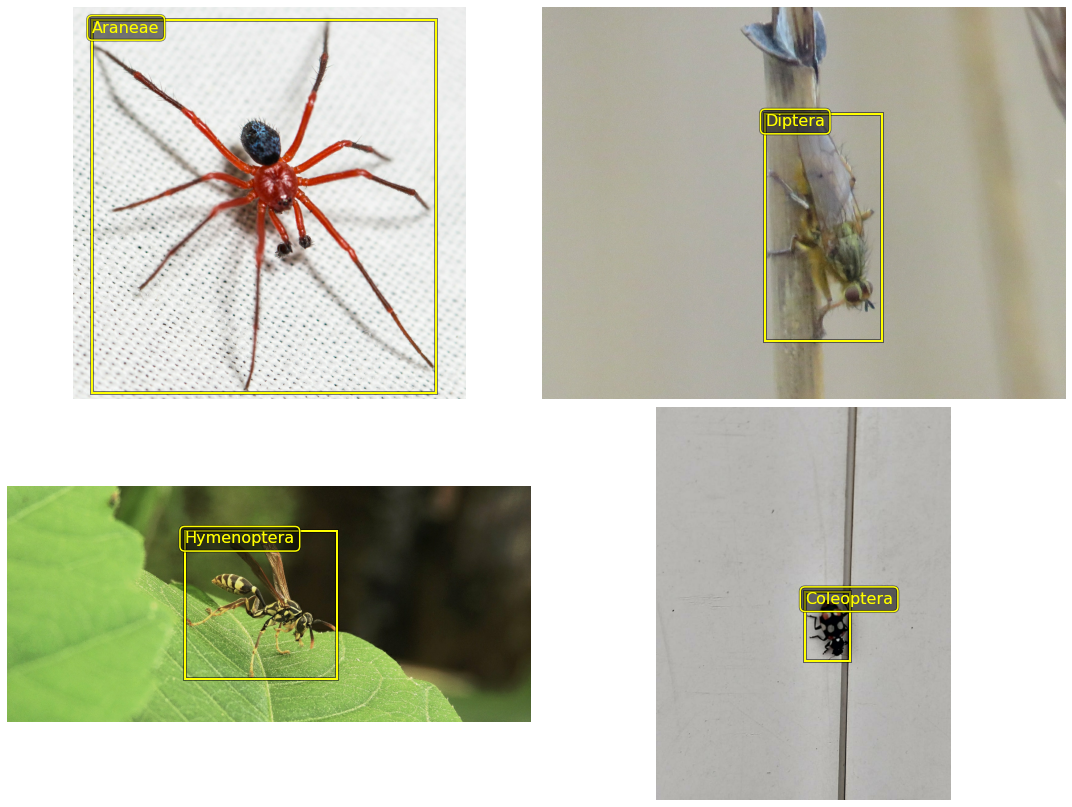

In [17]:
images, source_id, boxes, labels = next(dataset_iterator)
images = [im.numpy() for im in images] # must do this for ragged

# must scale the rois back to pixels for visualizatoin
image_shapes = [tf.cast((image.shape[1], image.shape[0]), tf.float32) for image in images]
boxes = [box.scale_rois(bbox, image_shapes[i]) for i,bbox in enumerate(boxes)]

#classes = [[CLASSES.index(label) for label in batchitem] for batchitem in labels]
display_with_boxes(images, boxes, labels, None, CLASSES, ground_truth_boxes=[])